# Evaluate the performance of the models

In [23]:
# import all of the packages that will be used

# basic packages for data processing
import pandas as pd
import numpy as np

# packege for calculation
import math

# packages for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from skelm import ELMClassifier

# packages to interpret the training result
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

# package to benchmark the CPU running time
import time 
from time import process_time

from memory_profiler import memory_usage
# silent the warning from sklearn package
# import warnings
# warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
import random
random.seed(10)
np.random.seed(10)

In [6]:
features = pd.read_csv('dataset/features_selected/CIC-IDS2018_RandomForestClassifier_20.csv').squeeze()
features = features[:11]

### Loading the dataset

In [7]:
columns = features.tolist() +  ['Label']

ids2018 = pd.read_csv('./dataset/dataset_cleaned/CSE-CIC-IDS2018_cleaned.csv', usecols=columns)
ids2018.shape
ids2018 = ids2018.sample(frac=0.1).reset_index(drop=True)

### Splitting data

In [8]:
ids2018_X = ids2018.drop('Label', axis=1).copy()
ids2018_y = ids2018['Label'].copy()

ids2018_train_X, ids2018_test_X, ids2018_train_y, ids2018_test_y = train_test_split(ids2018_X, ids2018_y, test_size=0.3)

### Scaling data

In [9]:
scalar = StandardScaler()

ids2018_train_X_scaled = scalar.fit_transform(ids2018_train_X)
ids2018_test_X_scaled = scalar.transform(ids2018_test_X)

### Model building

In [10]:
# Custom wrapper for ELMClassifier to define the missing `pairwise` tag
class CustomELMClassifier(ELMClassifier):
    def _get_tags(self):
        tags = super()._get_tags()
        # Add the missing pairwise tag
        tags['pairwise'] = False
        return tags


In [11]:
models = {
    'Decision Tree': tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=1.4401469385343852e-05),
    'Random Forest': RandomForestClassifier(max_depth=20, min_samples_leaf=0.00001, min_samples_split=0.00001, n_estimators=350, n_jobs=-1,criterion='gini'),
    'Naive Bayes': GaussianNB(var_smoothing=1.0),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', alpha=0.0001, solver='adam', max_iter=1000),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(15, 15, 15), activation='tanh', alpha=1e-05, solver='adam', max_iter=1000),
    'Extreme Learning Machine': CustomELMClassifier(n_neurons=7000, ufunc='relu', alpha=1e-05, batch_size=1000)
}

------------------------- Decision Tree -------------------------
              precision    recall  f1-score   support

      benign     0.9565    0.9509    0.9537      7721
   malicious     0.9514    0.9569    0.9541      7747

    accuracy                         0.9539     15468
   macro avg     0.9539    0.9539    0.9539     15468
weighted avg     0.9539    0.9539    0.9539     15468

------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign     0.9564    0.9891    0.9725      7721
   malicious     0.9888    0.9551    0.9716      7747

    accuracy                         0.9721     15468
   macro avg     0.9726    0.9721    0.9721     15468
weighted avg     0.9726    0.9721    0.9721     15468

------------------------- Naive Bayes -------------------------
              precision    recall  f1-score   support

      benign     0.7184    0.5006    0.5900      7721
   malicious     0.6178    0.8044    0.69

Text(0.5, 0.98, 'Confusion matrix of each model on CIC-IDS2018 dataset')

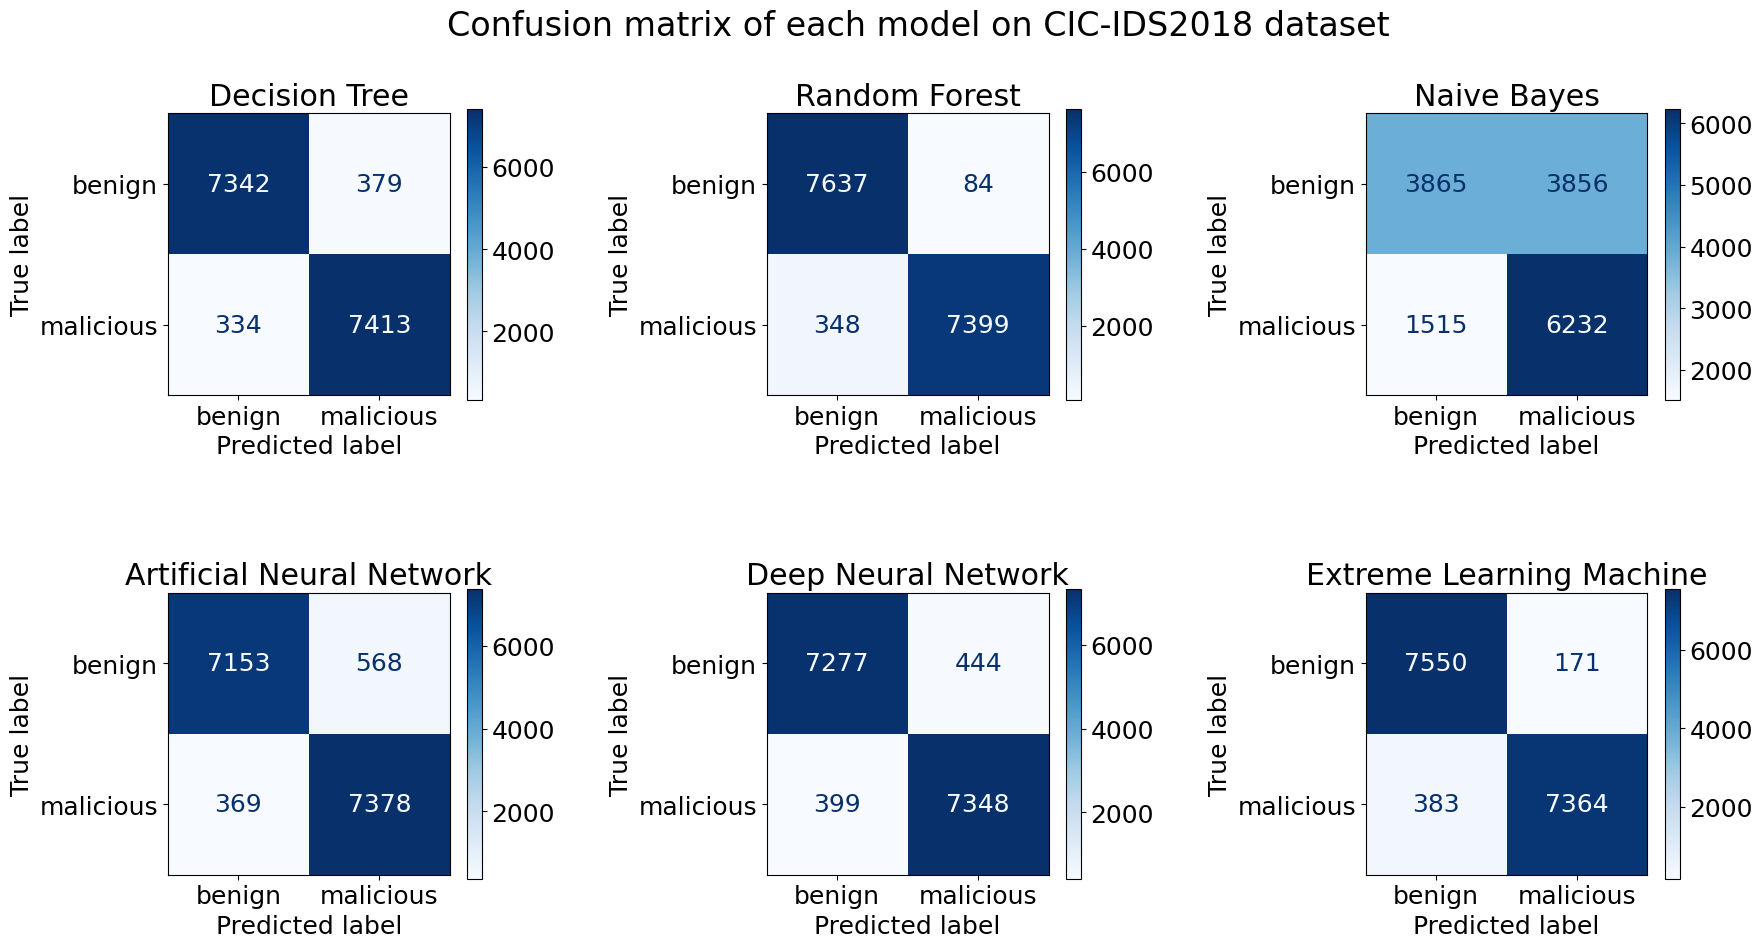

In [35]:
trained_models = {}
prediction_time = {}
prediction_memory_usage = {}
accuracy_testing_dataset = {}
f_score_testing_dataset = {}

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (model, clf) in enumerate(models.items()):

    clf.fit(ids2018_train_X_scaled, ids2018_train_y)

    # save the trained model
    trained_models[model] = clf

    # Track memory and time during prediction
    start_memory_pred = memory_usage()[0]
    prediction_start_time =  time.time()
    prediction = clf.predict(ids2018_test_X_scaled)
    # save the time and memory consumption for prediction
    prediction_time[model] = time.time() - prediction_start_time
    # Adding a small delay after prediction to help memory capture
    time.sleep(0.1)
    prediction_memory_usage[model] = memory_usage()[0] - start_memory_pred
    
    model_report = metrics.classification_report(ids2018_test_y, prediction, digits=4, output_dict=True)

    # save the accuracy and the f1-score of each model
    accuracy_testing_dataset[model] = model_report['accuracy']
    f_score_testing_dataset[model] = model_report['weighted avg']['f1-score']

    print(f"{'-'*25} {model} {'-'*25}")
    print(metrics.classification_report(ids2018_test_y, prediction, digits=4))

    ConfusionMatrixDisplay.from_estimator(clf, 
                            ids2018_test_X_scaled, 
                            ids2018_test_y, 
                            cmap=plt.cm.Blues,
                            ax=axes[math.floor(i/3)][i%3])

    axes[math.floor(i/3)][i%3].set_title(model)


fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CIC-IDS2018 dataset', fontsize=24)

### Comparison

In [13]:
# define function to create label on top of the bars
def label_top(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

### Accuracy

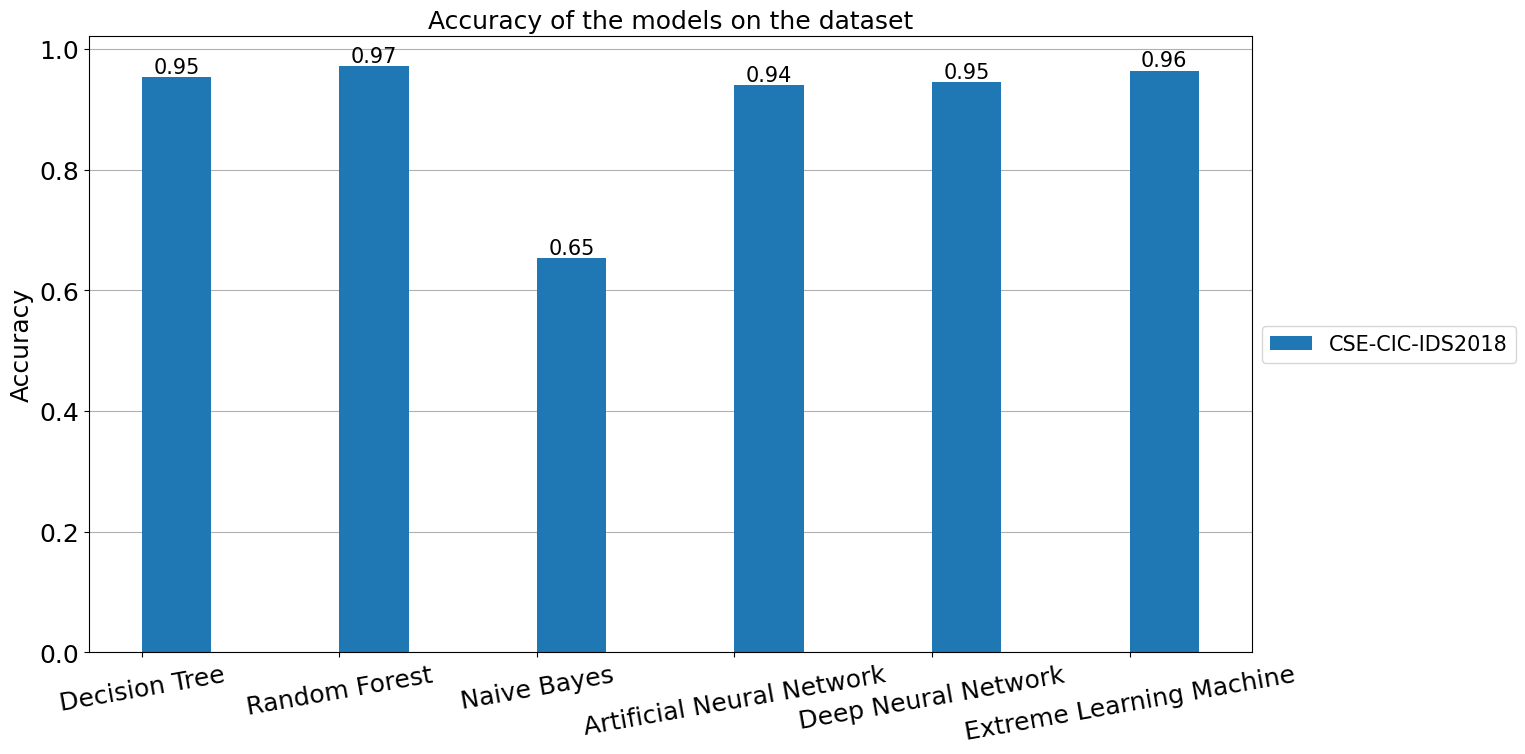

In [36]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(accuracy_testing_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x + width/2, accuracy_testing_dataset.values(), width, label='CSE-CIC-IDS2018')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of the models on the dataset')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_testing_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)

plt.show()

### F1-score

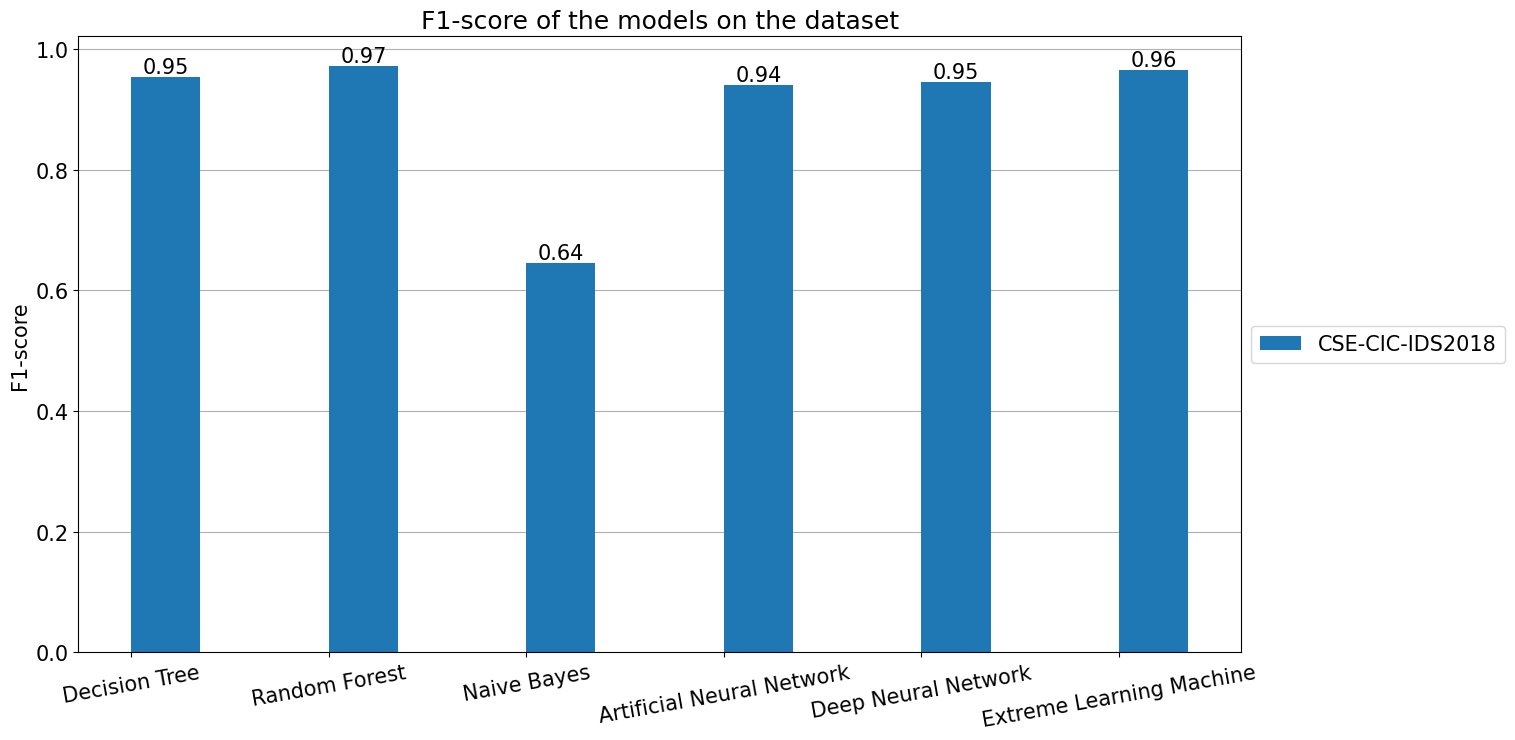

In [37]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(accuracy_testing_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x + width/2, f_score_testing_dataset.values(), width, label='CSE-CIC-IDS2018')

ax.set_ylabel('F1-score')
ax.set_title('F1-score of the models on the dataset')
ax.set_xticks(x)
ax.set_xticklabels(f_score_testing_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)

plt.show()

### Time consumption for prediction

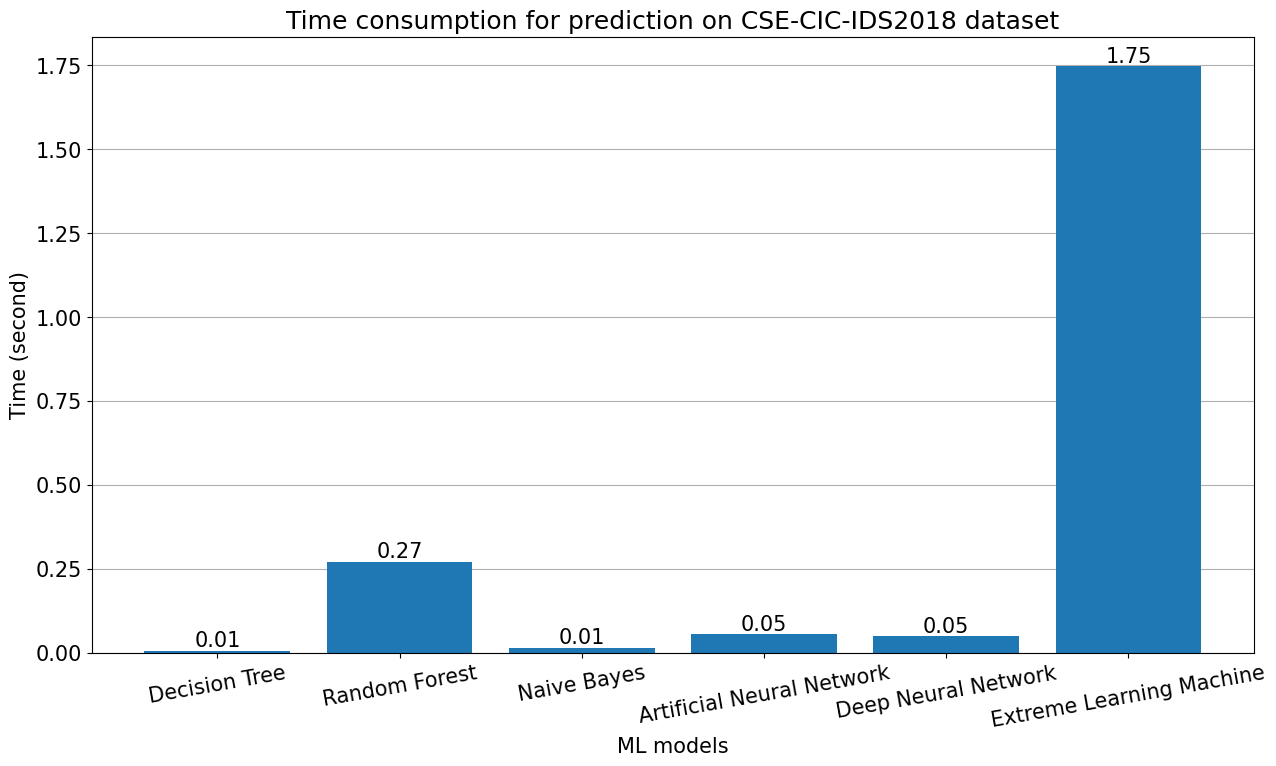

In [38]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(prediction_time.keys(), prediction_time.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Time (second)")
ax.set_title("Time consumption for prediction on CSE-CIC-IDS2018 dataset")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()

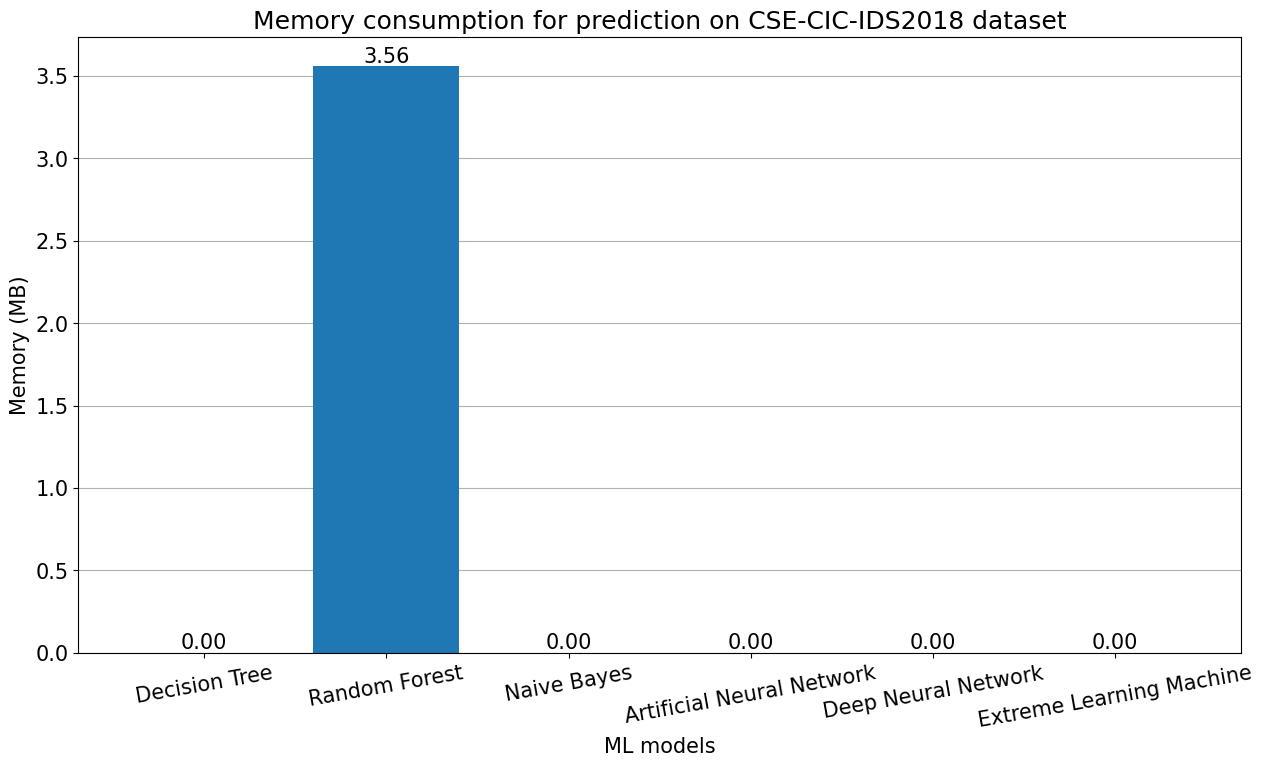

In [39]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(prediction_memory_usage.keys(), prediction_memory_usage.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Memory (MB)")
ax.set_title("Memory consumption for prediction on CSE-CIC-IDS2018 dataset")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()